In [ ]:
!pip install netCDF4
!pip install basemap

In [2]:
import scipy.io
import numpy as np
import pandas as pd
import netCDF4 as nc
from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning, message='\`np.bool\` is a deprecated alias')

# South America region
# already masked and averaged over the period
# masked out: all water areas, areas without natural vegetation (urban, glacier, ...), and with too much change in tree cover (deforestation and other).
# field has one time point (index 0), 102 latitudes and 110 longitudes

TreeCover_Rawdata = nc.Dataset('Am_MODIS_treeCover2000_2020CRUgrid_timmean_masked.nc', mode='r') # source: MODIS; period: 2000-2020
Prec_Rawdata = nc.Dataset('SA_pre_cru_ts4.06_1981_2020_ymean_timmean_masked.nc', mode='r') # source: CRU; period: 1981-2020
Temp_Rawdata = nc.Dataset('SA_tmp_cru_ts4.06_1981_2020_ymean_timmean_masked.nc', mode='r') # source: CRU; period: 1981-2020
PET_Rawdata = nc.Dataset('SA_pet_cru_ts4_01_1981_2016_timmean_masked.nc', mode='r') # source: CRU TS (Harris et al., 2020); period: 1981-2016; this is another source of PET received on Oct 24, 2023
SoilMoist_Rawdata = nc.Dataset('GLEAM_v3.7a_rootzone_soil_moisture_monthly_fv0.01_0.5deg_timmean_masked.nc', mode='r') # source: GLEAM (Miralles et al., 2011); period: 2001-2020
SoilDepth_Rawdata = nc.Dataset('soildepth_Pelletier2016_SA_0.5deg_timmean_masked.nc', mode='r') # source: Pelletier et al. (2016); period: 2001-2020
#Evaporation_Rawdata = nc.Dataset('GLEAM_v3.7a_potential_evaporation_monthly_fv0.01_0.5deg_timmean_masked.nc', mode='r') # source: GLEAM (Miralles et al., 2011); period: 1981-2020; potential evaporation = potential evapotranspiration (PET); data characteristics are different from the source CRU TS (Harris et al., 2020)
#PET_Rawdata = nc.Dataset('cru_ts4.01.1901.2016.pet.dat_timmean.nc', mode='r') # source: CRU TS; period 1901-2016; not masked and world wide map

TC0 = np.transpose(TreeCover_Rawdata.variables['treecover'][:], (0, 2, 1)) # this TC0 is in (time, lon, lat), so need to switch it to (time, lat, lon) like PR has
TC = np.where(TC0>0, TC0, np.nan)  # removing zeros in non land area (probably sea area); this would not remove the treeless tree cover
PR = Prec_Rawdata.variables['pre'][:]
TM = Temp_Rawdata.variables['tmp'][:]
PET = PET_Rawdata.variables['pet'][:]
SM0 = SoilMoist_Rawdata.variables['rootzone_soil_moisture'][:]
SM = np.where(SM0>0, SM0, np.nan) # removing zeros in non land area (probably sea area)
SD = SoilDepth_Rawdata.variables['soild'][:]

# Take information about the data
#print('===== TreeCover_Rawdata =====:\n', TreeCover_Rawdata)
#print('===== Prec_Rawdata =====:\n', Prec_Rawdata)
#print('===== Temp_Rawdata =====:\n', Temp_Rawdata)
#print('===== PET_Rawdata =====:\n', PET_Rawdata)
#print('===== SoilMoist_Rawdata =====:\n', SoilMoist_Rawdata)
#print('===== SoilDepth_Rawdata =====:\n', SoilDepth_Rawdata)

#### Figure 3.9 Data observation on the map of South America

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.font_manager import FontProperties
from pylab import *

TC0 = np.transpose(TreeCover_Rawdata.variables['treecover'][:], (0, 2, 1)) # this TC0 is in (time, lon, lat), so need to switch it to (time, lat, lon) like PR has
TC = np.where(TC0>0, TC0, np.nan)  # removing zeros in non land area (probably sea area); this would not remove the treeless tree cover
TC_lat_values = TreeCover_Rawdata.variables['lat'][:]
TC_lon_values = TreeCover_Rawdata.variables['lon'][:]

PR = Prec_Rawdata.variables['pre'][:]
PR_lat_values = Prec_Rawdata.variables['lat'][:]
PR_lon_values = Prec_Rawdata.variables['lon'][:]

TM = Temp_Rawdata.variables['tmp'][:]
TM_lat_values = Temp_Rawdata.variables['lat'][:]
TM_lon_values = Temp_Rawdata.variables['lon'][:]

SM0 = SoilMoist_Rawdata.variables['rootzone_soil_moisture'][:]
SM = np.where(SM0>0, SM0, np.nan) # removing zeros in non land area (probably sea area)
SM_lat_values = SoilMoist_Rawdata.variables['lat'][:]
SM_lon_values = SoilMoist_Rawdata.variables['lon'][:]

SD = SoilDepth_Rawdata.variables['soild'][:]
SD_lat_values = SoilDepth_Rawdata.variables['lat'][:]
SD_lon_values = SoilDepth_Rawdata.variables['lon'][:]

EV0 = Evaporation_Rawdata.variables['potential_evaporation'][:]
EV = np.where(EV0>0, EV0, np.nan) # removing zeros in non land area (probably sea area)
EV_lat_values = Evaporation_Rawdata.variables['lat'][:]
EV_lon_values = Evaporation_Rawdata.variables['lon'][:]

PET = PET_Rawdata.variables['pet'][:]
PET_lat_values = PET_Rawdata.variables['lat'][:]
PET_lon_values = PET_Rawdata.variables['lon'][:]

def plot_map(data, lat, lon, datacategory, cbar_label, title, use_contourf=True):
    lat_min = -60  # Minimum latitude for South America
    lat_max = 15   # Maximum latitude for South America
    lon_min = -90  # Minimum longitude for South America
    lon_max = -30  # Maximum longitude for South America
    
    # Extract the relevant region from the tree cover dataset
    #tree_cover_sa = tree_cover[:, (lat >= lat_min) & (lat <= lat_max), (lon >= lon_min) & (lon <= lon_max)]
    
    # Compute the average tree cover across time
    if datacategory == 'SD': data_avg = data
    else: data_avg = np.mean(data, axis=0)
    
    # Create the Basemap object for South America
    m = Basemap(llcrnrlon=lon_min, llcrnrlat=lat_min, urcrnrlon=lon_max, urcrnrlat=lat_max, resolution='l')
    
    # Create a meshgrid of latitudes and longitudes
    lon_mesh, lat_mesh = np.meshgrid(lon, lat)
    
    # Convert latitudes and longitudes to x, y coordinates
    x, y = m(lon_mesh, lat_mesh)
    
    # Plot the tree cover as a pcolormesh
    plt.figure(figsize=(8, 6))
    
    if use_contourf:
        if datacategory == 'TC': m.contourf(x, y, data_avg, cmap='YlGn', latlon=True) #YlGn
        elif datacategory == 'PR': m.contourf(x, y, np.where((data_avg>0)&(data_avg<=4000), data_avg, np.nan), cmap='YlGnBu', latlon=True)
        elif datacategory == 'TM': m.contourf(x, y, data_avg, cmap='RdYlBu_r', latlon=True)
        elif datacategory == 'SD': m.contourf(x, y, data_avg, cmap='YlOrBr', latlon=True)
        elif datacategory == 'SM': m.contourf(x, y, data_avg, cmap='GnBu', latlon=True)  
        elif datacategory == 'EV': m.contourf(x, y, data_avg, cmap='Spectral_r', latlon=True)
        elif datacategory == 'PET': m.contourf(x, y, data_avg, cmap='Spectral_r', latlon=True)
            
    else:
        if datacategory == 'TC': m.pcolormesh(x, y, data_avg, cmap='YlGn', latlon=True)
        elif datacategory == 'PR': m.pcolormesh(x, y, np.where((data_avg>0)&(data_avg<=4000), data_avg, np.nan), cmap='YlGnBu', latlon=True)
        elif datacategory == 'TM': m.pcolormesh(x, y, data_avg, cmap='RdYlBu_r', latlon=True)
        elif datacategory == 'SD': m.pcolormesh(x, y, data_avg, cmap='YlOrBr', latlon=True)
        elif datacategory == 'SM': m.pcolormesh(x, y, data_avg, cmap='GnBu', latlon=True)
        elif datacategory == 'EV': m.pcolormesh(x, y, data_avg, cmap='Spectral_r', latlon=True)
        elif datacategory == 'PET': m.pcolormesh(x, y, data_avg, cmap='Spectral_r', latlon=True)
    
    # Add map features
    m.drawcoastlines(linewidth = .3)
    m.drawcountries(linewidth = .3)
    m.drawmapboundary() # alternative background: m.shadedrelief() or m.drawmapboundary() or m.bluemarble()
    m.drawparallels(np.arange(lat_min, lat_max + 1, 10), labels=[1, 0, 0, 0], linewidth = .3)
    m.drawmeridians(np.arange(lon_min, lon_max + 1, 10), labels=[0, 0, 0, 1], linewidth = .3)
    
    # Add a colorbar
    cbar = m.colorbar(extend='neither')
    cbar.set_label(cbar_label, fontsize=14)
    
    plt.title(title, fontsize=16)
    plt.show()

plot_map(TC, TC_lat_values, TC_lon_values, 'TC', 'Tree Cover [%]', 'Tree Cover in South America')
plot_map(PR, PR_lat_values, PR_lon_values, 'PR', 'Precipitation [mm/yr]', 'Precipitation in South America')
plot_map(TM, TM_lat_values, TM_lon_values, 'TM', 'Temperature [°C]', 'Temperature in South America')
plot_map(SD, SD_lat_values, SD_lon_values, 'SD', 'Soil Depth [m]', 'Soil Depth in South America')
plot_map(SM, SM_lat_values, SM_lon_values, 'SM', 'Soil Moisture [m3/m3]', 'Soil Moisture in South America')
plot_map(PET, EV_lat_values, EV_lon_values, 'PET', 'PET [mm/yr]', 'PET in South America')
#plot_map(EV, EV_lat_values, EV_lon_values, 'EV', 'PET [mm/month]', 'PET in South America')

#### Figure 3.10 Frequency distribution of the dataset of each variable

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4,3))
sns.histplot(TC.flatten(), kde=True, bins=40, color='royalblue', fill=False) # removed zero values
plt.xlabel('Tree Cover [%]', weight='bold')
plt.ylabel('Frequency', weight='bold')
plt.title('Tree Cover frequency', weight='bold')
plt.show()

plt.figure(figsize=(4,3))
sns.histplot(np.where((PR>=0)&(PR<=4000), PR, np.nan).flatten(), kde=True, bins=40, color='royalblue', fill=False)
plt.xlabel('Precipitation [mm/year]', weight='bold')
plt.ylabel('Frequency', weight='bold')
plt.title('Precipitation frequency', weight='bold')
plt.show()

plt.figure(figsize=(4,3))
sns.histplot(TM[0,:,:].flatten(), kde=True, bins=40, color='royalblue', fill=False)
plt.xlabel('Temperature [°C]', weight='bold')
plt.ylabel('Frequency', weight='bold')
plt.title('Temperature frequency', weight='bold')
plt.show()

plt.figure(figsize=(4,3))
sns.histplot(PET.flatten(), kde=True, bins=40, color='royalblue', fill=False)
plt.xlabel('PET [mm/year]', weight='bold')
plt.ylabel('Frequency', weight='bold')
plt.title('PET frequency', weight='bold')
plt.show()

plt.figure(figsize=(4,3))
sns.histplot(SM.flatten(), kde=True, bins=40, color='royalblue', fill=False)
plt.xlabel('Soil Moisture [m3/m3]', weight='bold')
plt.ylabel('Frequency', weight='bold')
plt.title('Soil Moisture frequency', weight='bold')
plt.show()

plt.figure(figsize=(4,3))
sns.histplot(SD.flatten(), kde=True, bins=40, color='royalblue', fill=False)
plt.xlabel('Soil Depth [m]', weight='bold')
plt.ylabel('Frequency', weight='bold')
plt.title('Soil Depth frequency', weight='bold')
plt.show()

#### Figure 3.11 Scatter plot of the dataset between tree cover and one of other variables

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Tree cover vs. Precipitation
plt.figure(figsize=(4,3))
plt.scatter(PR, TC, s=1, color='black')
plt.vlines(x=1700, ymin=-5, ymax=105, colors='r')
plt.vlines(x=2100, ymin=-5, ymax=105, colors='r')
plt.xlabel('Precipitation [mm/yr]', weight='bold')
plt.ylabel('Tree cover [%]', weight='bold')
plt.xlim(-100, 4100)
plt.ylim(-5, 105)
plt.show()

# Tree cover vs. Temperature
plt.figure(figsize=(4,3))
plt.scatter(TM, TC, s=1, color='black')
plt.xlabel('Temperature [°C]', weight='bold')
plt.ylabel('Tree Cover [%]', weight='bold')
plt.xlim(-1, 31)
plt.ylim(-5, 105)
plt.show()

# Tree cover vs. PET
plt.figure(figsize=(4,3))
plt.scatter(PET, TC, s=1, color='black')
plt.xlabel('PET [mm/yr]', weight='bold')
plt.ylabel('Tree Cover [%]', weight='bold')
plt.ylim(-5, 105)
plt.show()

# Tree cover vs. Soil moisture
plt.figure(figsize=(4,3))
plt.scatter(SM, TC, s=1, color='black')
plt.xlabel('Soil Moisture [m3/m3]', weight='bold')
plt.ylabel('Tree Cover [%]', weight='bold')
plt.xlim(-0.02, 0.52)
plt.ylim(-5, 105)
plt.show()

# Tree cover vs. Soil depth
plt.figure(figsize=(4,3))
plt.scatter(SD, TC, s=1, color='black')
plt.xlabel('Soil Depth [m]', weight='bold')
plt.ylabel('Tree Cover [%]', weight='bold')
plt.ylim(-5, 105)
plt.show()

#### Figure 3.12 Scatter plot of the dataset between tree cover and precipitation with third variable in color scale

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Temperature in color scale
plt.figure(figsize=(4,3))
plt.scatter(PR, np.where(TC>0, TC, np.nan), s=1, c=TM, cmap='seismic')
plt.xlim(-100, 4100)
plt.ylim(-5, 105)
plt.xlabel('Precipitation [mm/yr]', weight='bold')
plt.ylabel('Tree cover [%]', weight='bold')
cbar = plt.colorbar(extend='max')
cbar.set_label('Temperature [°C]', weight='bold')
plt.show()

# PET in color scale
plt.figure(figsize=(4,3))
plt.scatter(PR, np.where(TC>0, TC, np.nan), s=1, c=PET, cmap='seismic')
plt.xlim(-100, 4100)
plt.ylim(-5, 105)
plt.xlabel('Precipitation [mm/yr]', weight='bold')
plt.ylabel('Tree cover [%]', weight='bold')
cbar = plt.colorbar(extend='max')
cbar.set_label('PET [mm/yr]', weight='bold')
plt.show()

# Soil moisture in color scale
plt.figure(figsize=(4,3))
plt.scatter(PR, np.where(TC>0, TC, np.nan), s=1, c=SM, cmap='seismic')
plt.xlim(-100, 4100)
plt.ylim(-5, 105)
plt.xlabel('Precipitation [mm/yr]', weight='bold')
plt.ylabel('Tree cover [%]', weight='bold')
cbar = plt.colorbar(extend='max')
cbar.set_label('Soil Moisture [m3/m3]', weight='bold')
plt.show()

# Soil depth in color scale
plt.figure(figsize=(4,3))
plt.scatter(PR, np.where(TC>0, TC, np.nan), s=1, c=SD, cmap='seismic')
plt.xlim(-100, 4100)
plt.ylim(-5, 105)
plt.xlabel('Precipitation [mm/yr]', weight='bold')
plt.ylabel('Tree cover [%]', weight='bold')
cbar = plt.colorbar(extend='max')
cbar.set_label('Soil Depth [m]', weight='bold')
plt.show()

#### Figure 3.13 Scatter plot of the dataset between precipitation and one of other variables

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Precipitation vs. Temperature
tempRng=np.linspace(2,28,100)
plt.figure(figsize=(4,3))
plt.scatter(TM, PR, s=1, color='black') # plt.scatter(TM, np.log(PR), s=1, color='black') # log-scale picture is not interested
plt.plot(tempRng, 3000/(28-tempRng) + 300, 'r')
plt.xlabel('Temperature [°C]', weight='bold')
plt.ylabel('Precipitation [mm/yr]', weight='bold')
plt.xlim(-1, 31)
plt.ylim(-200, 4200)
plt.show()

# Precipitation vs. PET
plt.figure(figsize=(4,3))
plt.scatter(PET, PR, s=1, color='black')
plt.xlabel('PET [mm/yr]', weight='bold')
plt.ylabel('Precipitation [mm/yr]', weight='bold')
plt.ylim(-200, 4200)
plt.show()

# Precipitation vs. Soil moisture
plt.figure(figsize=(4,3))
plt.scatter(SM, PR, s=1, color='black')
plt.xlabel('Soil Moisture [m3/m3]', weight='bold')
plt.ylabel('Precipitation [mm/yr]', weight='bold')
plt.xlim(-0.02, 0.52)
plt.ylim(-200, 4200)
plt.show()

# Precipitation vs. Soil depth
plt.figure(figsize=(4,3))
plt.scatter(SD, PR, s=1, color='black')
plt.xlabel('Soil Depth [m]', weight='bold')
plt.ylabel('Precipitation [mm/yr]', weight='bold')
plt.ylim(-200, 4200)
plt.show()

#### Figure 3.14 Distribution of the variable in the intermediate range of precipitation 1700-2100 mm/year

corr_TC_PR_for 1700≤P≤2100mm/yr= 0.53
corr_TC_TM_for 1700≤P≤2100mm/yr= 0.22
corr_TC_PET_for 1700≤P≤2100mm/yr= -0.3
corr_TC_SM_for 1700≤P≤2100mm/yr= 0.04
corr_TC_SD_for 1700≤P≤2100mm/yr= -0.19
corr_TC_PR_original_for all P range= 0.7331812394208925
corr_PR_PET_original_for all P range= -0.5094798952336014


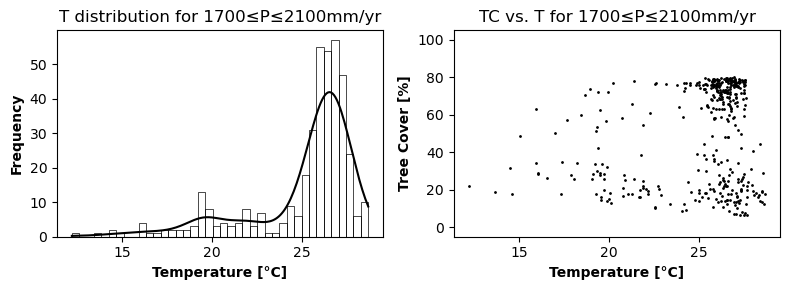

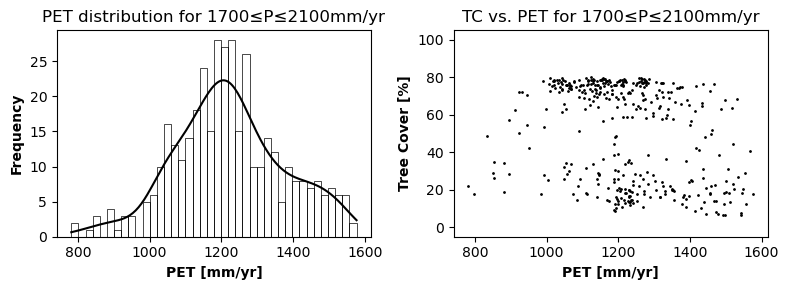

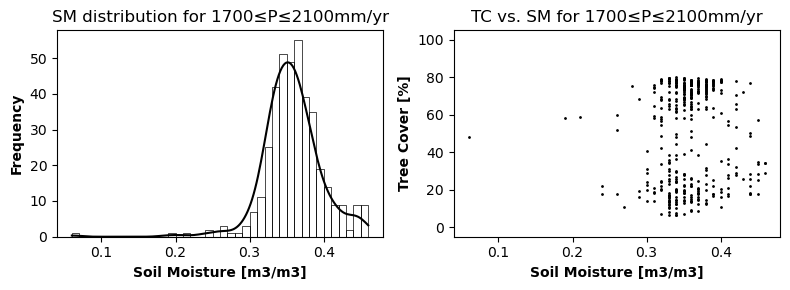

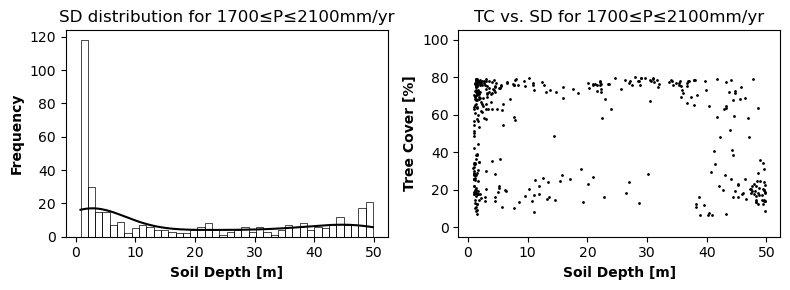

In [15]:
import numpy as np
import numpy.ma as ma
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats

TC_selected = TC[(PR>=1700)&(PR<=2100)]
PR_selected = PR[(PR>=1700)&(PR<=2100)]
TM_selected = TM[(PR>=1700)&(PR<=2100)]
PET_selected = PET[(PR>=1700)&(PR<=2100)]
SM_selected = SM[(PR>=1700)&(PR<=2100)]
SD_selected = SD[(PR[0,:,:]>=1700)&(PR[0,:,:]<=2100)]

TC_flattened = TC_selected.flatten()
PR_flattened = PR_selected.flatten()
TM_flattened = TM_selected.flatten()
PET_flattened = PET_selected.flatten()
SM_flattened = SM_selected.flatten()
SD_flattened = SD_selected.flatten()

TC_flattened_original = TC[(TC>=0)&(TC<=100)].flatten()
PR_flattened_original = PR[(TC>=0)&(TC<=100)].flatten()
PET_flattened_original = PET[(TC>=0)&(TC<=100)].flatten()

corrcoef_TC_PR = round(np.ma.corrcoef(PR_flattened, TC_flattened)[0,1],2)
corrcoef_TC_TM = round(np.ma.corrcoef(TM_flattened, TC_flattened)[0,1],2)
corrcoef_TC_PET = round(np.ma.corrcoef(PET_flattened, TC_flattened)[0,1],2)
corrcoef_TC_SM = round(np.ma.corrcoef(SM_flattened, TC_flattened)[0,1],2)
corrcoef_TC_SD = round(np.ma.corrcoef(SD_flattened, TC_flattened)[0,1],2)

corrcoef_TC_PR_original = np.ma.corrcoef(PR_flattened_original, TC_flattened_original)[0,1]
corrcoef_PR_PET_original = np.ma.corrcoef(PR_flattened_original, PET_flattened_original)[0,1]

print('corr_TC_PR_for 1700≤P≤2100mm/yr=', corrcoef_TC_PR)
print('corr_TC_TM_for 1700≤P≤2100mm/yr=', corrcoef_TC_TM)
print('corr_TC_PET_for 1700≤P≤2100mm/yr=', corrcoef_TC_PET)
print('corr_TC_SM_for 1700≤P≤2100mm/yr=', corrcoef_TC_SM)
print('corr_TC_SD_for 1700≤P≤2100mm/yr=', corrcoef_TC_SD)

print('corr_TC_PR_original_for all P range=', corrcoef_TC_PR_original)
print('corr_PR_PET_original_for all P range=', corrcoef_PR_PET_original)

fig = plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
sns.histplot(TM[(PR>=1700)&(PR<=2100)].flatten(), kde=True, color='black', bins=40, fill=False)
plt.title('T distribution for 1700≤P≤2100mm/yr')
plt.xlabel('Temperature [°C]', weight='bold')
plt.ylabel('Frequency', weight='bold')
plt.subplot(1,2,2)
plt.scatter(TM[(PR>=1700)&(PR<=2100)], TC[(PR>=1700)&(PR<=2100)], s=1, color='black')
plt.title('TC vs. T for 1700≤P≤2100mm/yr')
plt.ylim(-5,105)
plt.xlabel('Temperature [°C]', weight='bold')
plt.ylabel('Tree Cover [%]', weight='bold')
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
sns.histplot(PET[(PR>=1700)&(PR<=2100)].flatten(), kde=True, color='black', bins=40, fill=False)
plt.title('PET distribution for 1700≤P≤2100mm/yr')
plt.xlabel('PET [mm/yr]', weight='bold')
plt.ylabel('Frequency', weight='bold')
plt.subplot(1,2,2)
plt.scatter(PET[(PR>=1700)&(PR<=2100)], TC[(PR>=1700)&(PR<=2100)], s=1, color='black')                      # regression line
plt.title('TC vs. PET for 1700≤P≤2100mm/yr')
plt.ylim(-5,105)
plt.xlabel('PET [mm/yr]', weight='bold')
plt.ylabel('Tree Cover [%]', weight='bold')
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
sns.histplot(SM[(PR>=1700)&(PR<=2100)].flatten(), kde=True, color='black', bins=40, fill=False)
plt.title('SM distribution for 1700≤P≤2100mm/yr')
plt.xlabel('Soil Moisture [m3/m3]', weight='bold')
plt.ylabel('Frequency', weight='bold')
plt.subplot(1,2,2)
plt.scatter(SM[(PR>=1700)&(PR<=2100)], TC[(PR>=1700)&(PR<=2100)], s=1, color='black')
plt.title('TC vs. SM for 1700≤P≤2100mm/yr')
plt.ylim(-5,105)
plt.xlabel('Soil Moisture [m3/m3]', weight='bold')
plt.ylabel('Tree Cover [%]', weight='bold')
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
sns.histplot(SD[(PR[0,:,:]>=1700)&(PR[0,:,:]<=2100)].flatten(), kde=True, color='black', bins=40, fill=False)
plt.title('SD distribution for 1700≤P≤2100mm/yr')
plt.xlabel('Soil Depth [m]', weight='bold')
plt.ylabel('Frequency', weight='bold')
plt.subplot(1,2,2)
plt.scatter(SD[(PR[0,:,:]>=1700)&(PR[0,:,:]<=2100)], TC[(PR>=1700)&(PR<=2100)], s=1, color='black')
plt.title('TC vs. SD for 1700≤P≤2100mm/yr')
plt.ylim(-5,105)
plt.xlabel('Soil Depth [m]', weight='bold')
plt.ylabel('Tree Cover [%]', weight='bold')
plt.tight_layout()
plt.show()